<a href="https://colab.research.google.com/github/PerezSebas14/diplomado/blob/main/Ventas_de_la_tienda_Rossmann.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Contexto del problema**

Rossmann opera más de 3.000 farmacias en 7 países europeos. Actualmente, los gerentes de las tiendas Rossmann tienen la tarea de predecir sus ventas diarias con hasta seis semanas de anticipación. Las ventas en las tiendas están influenciadas por muchos factores, incluidas las promociones, la competencia, las vacaciones escolares y estatales, la estacionalidad y la localidad. Con miles de gerentes individuales que predicen las ventas en función de sus circunstancias únicas, la precisión de los resultados puede variar bastante.
https://www.kaggle.com/c/rossmann-store-sales

#**2. Conocimiento de los datos**


**Importar librerías**

In [1]:
import numpy as np # Cálculos matemáticos - Muy popular para el procesamiento de matrices y matrices multidimensionales de gran tamaño
import pandas as pd # Depuración de datos - Análisis y tratamiento de datos
import matplotlib.pyplot as plt # Gráficos estadísticos
import seaborn as sns # Gráficos estadísticos
from scipy.stats import shapiro # Pruebas de hipótesis
from scipy.stats import chi2_contingency # Pruebas de hipótesis


# Modelación en ML
from sklearn.model_selection import  train_test_split # Dividir la data en entrenamiento y prueba

In [2]:
pd.options.display.float_format = "{:.6f}".format

**Importar los datos**
Descripciones de archivos
* store.csv : información complementaria sobre las tiendas
* train.csv : datos históricos que incluyen ventas
* test.csv - datos históricos excluyendo ventas
* sample_submission.csv : un archivo de envío de muestra en el formato correcto



In [3]:
# Detalles de cada tienda
store = pd.read_csv("/content/drive/MyDrive/Diplomado Big Data/2. Análisis Descriptivo y Exploratorio/Insumos/rossmann-store-sales/store.csv")
# ventas históricas de todas las tiendas (desde el 1 de enero de 2013 hasta 31 jul de 2015)
train = pd.read_csv("/content/drive/MyDrive/Diplomado Big Data/2. Análisis Descriptivo y Exploratorio/Insumos/rossmann-store-sales/train.csv")
# Tiendas y fechas a realizarles la predicción (Desde el 1 de agosto de 2015 hasta el 17 de septiembre de 2015)
test = pd.read_csv("/content/drive/MyDrive/Diplomado Big Data/2. Análisis Descriptivo y Exploratorio/Insumos/rossmann-store-sales/test.csv")
# Archivo con el formato final a entregar con la predicción
sample_submission = pd.read_csv("/content/drive/MyDrive/Diplomado Big Data/2. Análisis Descriptivo y Exploratorio/Insumos/rossmann-store-sales/sample_submission.csv")


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# ventas históricas de todas las tiendas (Como la base original no contiene ningún NA, se altera desde el origen con N/A para realizar la práctrica de datos perdidos e imputación)
train_NA = pd.read_csv("/content/drive/MyDrive/Diplomado Big Data/2. Análisis Descriptivo y Exploratorio/Insumos/rossmann-store-sales/train_Con_NA.csv", sep=';')

**Revisamos la data histórica**

**Dimensión de la data histórica (Cuántas filas y columnas tiene)**

In [5]:
train.shape

(1017209, 9)

In [6]:
train_NA.shape

(1017209, 9)

**Dimensión de la data activa (tiendas y fechas a las que se les va a predecir las ventas)**

In [7]:
test.shape

(41088, 8)

**Estructura de la data**

In [8]:
train.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [9]:
train_NA.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,2,1/1/2013,0.000000,0,0,0,a,1
1,2,5,31/7/2015,6064.000000,625,1,1,0,1
2,3,5,31/7/2015,8314.000000,821,1,1,0,1
3,4,5,31/7/2015,13995.000000,1498,1,1,0,1
4,5,5,31/7/2015,4822.000000,559,1,1,0,1


In [10]:
test.head(5)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.000000,1,0,0
1,2,3,4,2015-09-17,1.000000,1,0,0
2,3,7,4,2015-09-17,1.000000,1,0,0
3,4,8,4,2015-09-17,1.000000,1,0,0
4,5,9,4,2015-09-17,1.000000,1,0,0


**Diccionario de la base de datos**
* **Assortment - Surtido**: describe un nivel de surtido: a = básico, b = extra, c = extendido
* **CompetitionDistance** - distancia en metros hasta la tienda competidora más cercana
* **CompetitionOpenSince [Month / Year]**: proporciona el año y el mes aproximados del momento en que se abrió el competidor más cercano.
* **Customers**: el número de clientes en un día determinado.
* **Id**: un Id que representa un dúplex (Store, Date) dentro del conjunto de prueba
* **Open**: un indicador de si la tienda estaba abierta: 0 = cerrada, 1 = abierta
* **Promo**: indica si una tienda está ejecutando una promoción ese día.
* **Promo2**: Promo2 es una promoción continua y consecutiva para algunas tiendas: 0 = la tienda no participa, 1 = la tienda participa
* **Promo2Since [Year / Week]**: describe el año y la semana calendario en que la tienda comenzó a participar en Promo2.
* **PromoInterval**: describe los intervalos consecutivos en que se inicia Promo2 , nombrando los meses en que la promoción se inicia de nuevo. Por ejemplo, "febrero, mayo, agosto, noviembre" significa que cada ronda comienza en febrero, mayo, agosto, noviembre de cualquier año para esa tienda.
* **Sales**: el volumen de ventas de un día determinado (esto es lo que está prediciendo)
* **SchoolHoliday**: indica si el (Store, Date) se vio afectado por el cierre de las escuelas públicas
* **StateHoliday**: indica un feriado estatal. Normalmente, todas las tiendas, con pocas excepciones, están cerradas los días festivos estatales. Tenga en cuenta que todas las escuelas están cerradas los días festivos y fines de semana. a = festivo, b = festivo de Pascua, c = Navidad, 0 = Ninguno
* **Store**: una identificación única para cada tienda
* **StoreType**: diferencia entre 4 modelos de tienda diferentes: a, b, c, d


# **3. Análisis exploratorio de datos (EDA)**

**Naturaleza de las variables**

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [12]:
train_NA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   Store          1017209 non-null  int64  
 1   DayOfWeek      1017209 non-null  int64  
 2   Date           1017209 non-null  object 
 3   Sales          1017168 non-null  float64
 4   Customers      1017209 non-null  int64  
 5   Open           1017209 non-null  int64  
 6   Promo          1017209 non-null  int64  
 7   StateHoliday   1017209 non-null  object 
 8   SchoolHoliday  1017209 non-null  int64  
dtypes: float64(1), int64(6), object(2)
memory usage: 69.8+ MB


**Recodificar la naturaleza de los datos**
Se revisan los datos y se cambia el tipo de datos a los que se requiera
* **Store:** texto
* **DayOfWeek:** texto
* **Date:** fecha
* **Sales:** numérico
* **Customers:** numérico
* **Open:** categórico
* **Promo:** categórico
* **StateHoliday:** categórico 
* **SchoolHoliday:** categórico


In [13]:
#Nombre de las variables
train.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday'],
      dtype='object')

In [14]:
train[["Store","DayOfWeek"]]=train[["Store","DayOfWeek"]].astype("str")

In [15]:
train["Date"]=train["Date"].astype('datetime64[ns]')

In [16]:
train[["Open","Promo","StateHoliday","SchoolHoliday"]]=train[["Open","Promo","StateHoliday","SchoolHoliday"]].astype('category')

In [17]:
train_NA["Store"]=train_NA["Store"].astype("str")

In [18]:
train_NA["Date"]=train_NA["Date"].astype('datetime64[ns]')

In [19]:
train_NA[["Open","Promo","StateHoliday","SchoolHoliday"]]=train_NA[["Open","Promo","StateHoliday","SchoolHoliday"]].astype('category')

In [20]:
train_NA["Sales"]=train_NA["Sales"].astype('Int64')

**Datos perdidos**

In [21]:
#El comando pd.options.display.max_rows=20 se utiliza en caso de que la funión train.isnull().sum() no nos muestre todas las variables
#En el agumento .max_rows=20 se le puede poner el número e acuerdo a las filas que se requiran ver
pd.options.display.max_rows=20
train.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [22]:
train_NA.isnull().sum()

Store             0
DayOfWeek         0
Date              0
Sales            41
Customers         0
Open              0
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

In [23]:
#Porcentaje de datos perdidos
train.isnull().sum()/len(train)

Store           0.000000
DayOfWeek       0.000000
Date            0.000000
Sales           0.000000
Customers       0.000000
Open            0.000000
Promo           0.000000
StateHoliday    0.000000
SchoolHoliday   0.000000
dtype: float64

In [24]:
(train_NA.isnull().sum()/len(train_NA))*100

Store           0.000000
DayOfWeek       0.000000
Date            0.000000
Sales           0.004031
Customers       0.000000
Open            0.000000
Promo           0.000000
StateHoliday    0.000000
SchoolHoliday   0.000000
dtype: float64

**1. Cuando la cantidad de datos perdidos en una variable sea superior al 50% del total de la data, esa variable se debe eliminar.**
* El comando **train=train.drop(["var1","var2","var3","var4"],axis=1)** nos permite eliminar las variables que cumplan con la condición 1

**2. Cuando a data perdida o N/A sea bajo < 30%, puedo imputarlo, alguna de las técnicas consiste en utilizar el promedio o la mediana de los datos**

**Como el % de datos perdidos n la variable Sales es menor que el 30% del total de los datos, vamos a imputar de 2 formas, una eliminando los NA y la otra a través de la estadística descriptiva**

##**Vamos a eliminar los NA**

In [122]:
train_sin_na=train_NA.dropna()

In [123]:
# Verificamos la cantidad de NA que quedaron después de eliminar
train_sin_na.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [124]:
# Verificamos el % de NA que quedaron después de eliminar
(train_sin_na.isnull().sum()/len(train_NA))*100

Store           0.000000
DayOfWeek       0.000000
Date            0.000000
Sales           0.000000
Customers       0.000000
Open            0.000000
Promo           0.000000
StateHoliday    0.000000
SchoolHoliday   0.000000
dtype: float64

In [125]:
len(train_NA)

1017209

In [126]:
len(train_sin_na)

1017209

In [127]:
#Cantidad de NA eliminados
len(train_NA)-len(train_sin_na)

0

In [128]:
# %de NA eliminados (no puede ser > 30%)
(len(train_NA)-len(train_sin_na))/len(train_NA)*100

0.0

**Imputar con estadística descriptiva**

**Imputar la variable Sales**

In [129]:
ventas_tienda_abierta = train_sin_na[train_sin_na["Open"]==1]

In [130]:
Ventas = ventas_tienda_abierta["Sales"]

In [131]:
Ventas

1          6064.000000
2          8314.000000
3         13995.000000
4          4822.000000
5          5651.000000
              ...     
1016776    3375.000000
1016827   10765.000000
1016863    5035.000000
1017042    4491.000000
1017190    5961.000000
Name: Sales, Length: 844392, dtype: float64

In [132]:
len(Ventas)

844392

**Distribución de los datos**

**Histográma**

In [133]:
promedio_con_atipicos = np.mean(Ventas) 

In [134]:
promedio_con_atipicos

6955.5849199704935

<function matplotlib.pyplot.show>

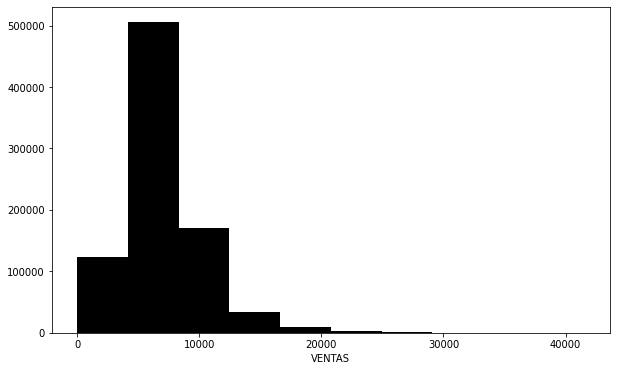

In [135]:
plt.figure(figsize=(10,6))
plt.hist(Ventas,facecolor="black")
plt.xlabel("VENTAS")
plt.show

##**Identificar datos atípicos**

**Manera visual: Boxplot**

In [39]:
Ventas.describe()

count   844351.000000
mean      6955.590101
std       3104.243795
min          0.000000
25%       4859.000000
50%       6369.000000
75%       8360.000000
max      41551.000000
Name: Sales, dtype: float64

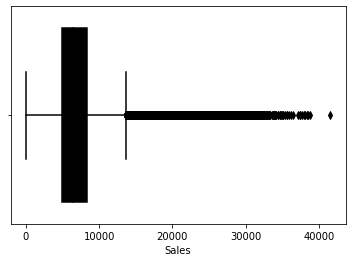

In [40]:
sns.boxplot(x=Ventas,color="black")

**Método del rargo intercuantil**

In [41]:
q1,q3=np.percentile(Ventas,[25,75])
print(q1)
print(q3)

4859.0
8360.0


**Calcular los límites**

In [42]:
#Rango intercuantil
RIC = (q3-q1)
print(RIC)

3501.0


In [43]:
Limite_Sup = round(q3+(1.5*RIC))
print(Limite_Sup)

13612


In [44]:
Limite_Inf = q1-(1.5*RIC)
print(Limite_Inf)

-392.5


**Graficar los puntos atípicos**

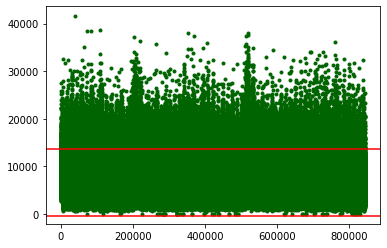

In [45]:
plt.plot(list(Ventas),".",color="darkgreen")
plt.axhline(y=Limite_Inf,color="red",linestyle="-")
plt.axhline(y=Limite_Sup,color="red",linestyle="-")
plt.show()

**Excluimos los datos atípicos**

In [46]:
train_sin_ventas_atipicas = train_sin_na[(train_sin_na["Sales"]<Limite_Sup) & (train_sin_na["Sales"]>Limite_Inf) & train_sin_na["Open"]==1] 

In [47]:
train_sin_ventas_atipicas.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
5,6,5,2015-07-31,5651,589,1,1,0,1
7,8,5,2015-07-31,8492,833,1,1,0,1


In [48]:
train_sin_ventas_atipicas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 813582 entries, 1 to 1017190
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Store          813582 non-null  object        
 1   DayOfWeek      813582 non-null  int64         
 2   Date           813582 non-null  datetime64[ns]
 3   Sales          813582 non-null  Int64         
 4   Customers      813582 non-null  int64         
 5   Open           813582 non-null  category      
 6   Promo          813582 non-null  category      
 7   StateHoliday   813582 non-null  category      
 8   SchoolHoliday  813582 non-null  category      
dtypes: Int64(1), category(4), datetime64[ns](1), int64(2), object(1)
memory usage: 41.1+ MB


In [49]:
Ventas_sin_atipicos = train_sin_ventas_atipicas["Sales"]

In [50]:
Ventas_sin_atipicos.describe()

count   813582.000000
mean      6584.646317
std       2421.534616
min          0.000000
25%       4802.000000
50%       6253.000000
75%       8080.000000
max      13611.000000
Name: Sales, dtype: float64

In [51]:
Ventas.describe()

count   844351.000000
mean      6955.590101
std       3104.243795
min          0.000000
25%       4859.000000
50%       6369.000000
75%       8360.000000
max      41551.000000
Name: Sales, dtype: float64

<function matplotlib.pyplot.show>

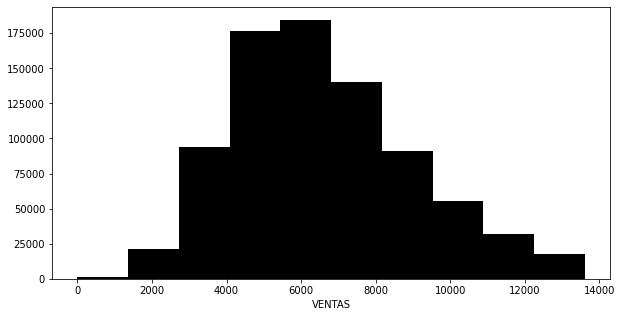

In [52]:
plt.figure(figsize=(10,5))
plt.hist(Ventas_sin_atipicos,facecolor="black")
plt.xlabel("VENTAS")
plt.show

In [53]:
promedio_con_atipicos

6955.590100562444

In [54]:
promedio_sin_atipicos = np.mean(Ventas_sin_atipicos)

In [55]:
promedio_sin_atipicos

6584.646317150576

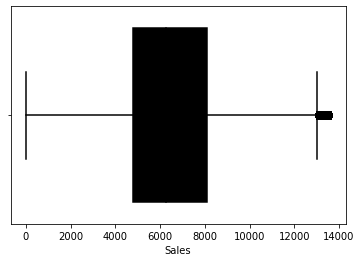

In [56]:
sns.boxplot(x=Ventas_sin_atipicos,color="black")

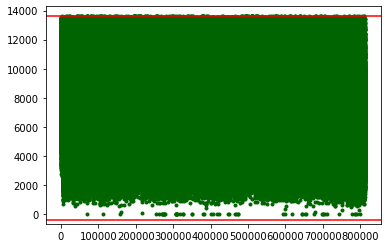

In [57]:
plt.plot(list(Ventas_sin_atipicos),".",color="darkgreen")
plt.axhline(y=Limite_Inf,color="red",linestyle="-")
plt.axhline(y=Limite_Sup,color="red",linestyle="-")
plt.show()

##**Validar normalidad**

**Test gráfico de normalidad qq-plot**

In [58]:
from statsmodels.graphics.gofplots import qqplot

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [59]:
#qqplot(Ventas_sin_atipicos,line="s")

**Test de Normalidad estadística**

In [60]:
#stat, p= shapiro(Ventas_sin_atipicos)
#p

In [61]:
#if (p <= 0.05):
#  print("La variable no es normal")
#else:
#  print("La variable es normal")

**Test de promedio**

In [62]:
from scipy.stats import ttest_1samp

In [63]:
print(promedio_sin_atipicos)

6584.646317150576


In [64]:
test,pvalor= ttest_1samp(Ventas_sin_atipicos,promedio_sin_atipicos)

In [65]:
pvalor

1.0

In [66]:
if (pvalor <= 0.05):
  print("El promedio no es el aproximado al real")
else:
  print("El promedio es el aproximado al real")

El promedio es el aproximado al real


## Enfoque no paramétrico para calcular un parámetro poblacional

**Enfoque o paramétrico** en Python apenas se está implementando, se hace mejor en R

**Remuestreo: Simulación computacional**

In [67]:
promedio_sin_atipicos

6584.646317150576

In [68]:
from random import sample
import math

**Seleccionamos muestra aleatoria**

In [69]:
Muestra = Ventas.sample(n=1000,replace=False)

In [70]:
len(Muestra)

1000

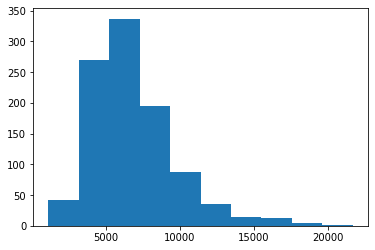

In [71]:
plt.hist(Muestra)
plt.show()

**Remuestreo**

In [72]:
Muestra_Promedios = [] #Lista vacía

In [73]:
for i in range(100000):
  Muestra_N= Muestra.sample(n=500,replace=True)
  Muestra_Promedios.append(Muestra_N.mean())

**Medias de medias remuestradas**

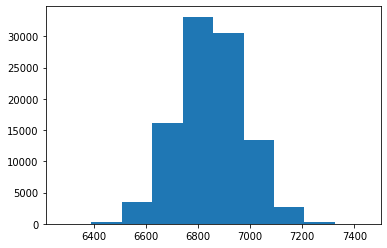

In [74]:
plt.hist(Muestra_Promedios)
plt.show()

In [75]:
Muestra_Promedios1 = pd.Series(Muestra_Promedios)

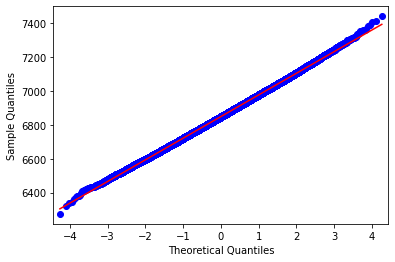

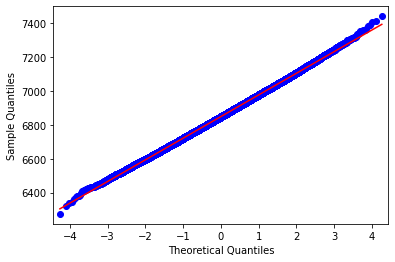

In [76]:
qqplot(Muestra_Promedios1,line="s")

In [77]:
Promedio_Remuestreo = np.mean(Muestra_Promedios1)
print(Promedio_Remuestreo)

6848.896188380021


In [78]:
promedio_sin_atipicos

6584.646317150576

In [79]:
ventas_tienda_abierta = train[train["Open"]==1]

In [80]:
ventas_train = ventas_tienda_abierta["Sales"]

In [81]:
promedio_original = np.mean(ventas_train)
print(promedio_original)

6955.514290755952


##Imputar NA con promedio

In [82]:
train_NA["Sales"]=train_NA["Sales"].replace(np.nan,Promedio_Remuestreo)

In [83]:
train_NA.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [84]:
ventas_trainNA_tienda_abierta = train_NA[train_NA["Open"]==1]

In [85]:
ventas_trainNA = ventas_trainNA_tienda_abierta["Sales"]

In [86]:
promedio_trainNA = np.mean(ventas_trainNA)
print(promedio_trainNA)

6955.5849199704935


## Análisis de variables categóricas



In [87]:
train = train[train["Open"]==1]

**1. Variable Promo**

In [88]:
pd.value_counts(train["Promo"])

0    467496
1    376896
Name: Promo, dtype: int64

**Distribucion %**

In [89]:
(pd.value_counts(train["Promo"])/len(train))*100

0   55.364807
1   44.635193
Name: Promo, dtype: float64

**Grafico**

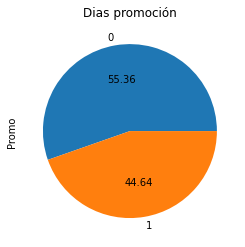

In [90]:
plot = train["Promo"].value_counts().plot(kind="pie",autopct="%.2f",title="Dias promoción")

**2. Variable SchoolHoliday**

In [91]:
pd.value_counts(train["SchoolHoliday"])

0    680935
1    163457
Name: SchoolHoliday, dtype: int64

**Distribucion %**

In [92]:
(pd.value_counts(train["SchoolHoliday"])/len(train))*100

0   80.642048
1   19.357952
Name: SchoolHoliday, dtype: float64

**Grafico**

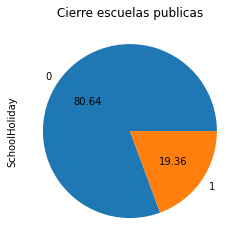

In [93]:
plot = train["SchoolHoliday"].value_counts().plot(kind="pie",autopct="%.2f",title="Cierre escuelas publicas")

**3. Variable StateHoliday**

In [94]:
pd.value_counts(train["StateHoliday"])

0    731342
0    112140
a       694
b       145
c        71
Name: StateHoliday, dtype: int64

**Distribucion %**

In [95]:
(pd.value_counts(train["StateHoliday"])/len(train))*100

0   86.611669
0   13.280562
a    0.082189
b    0.017172
c    0.008408
Name: StateHoliday, dtype: float64

**Grafico**

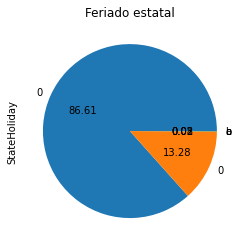

In [96]:
plot = train["StateHoliday"].value_counts().plot(kind="pie",autopct="%.2f",title="Feriado estatal")

**4. Variable DayOfWeek**

In [97]:
pd.value_counts(train["DayOfWeek"])

6    144058
2    143961
3    141936
5    138640
1    137560
4    134644
7      3593
Name: DayOfWeek, dtype: int64

**Distribucion %**

In [98]:
(pd.value_counts(train["DayOfWeek"])/len(train))*100

6   17.060560
2   17.049072
3   16.809254
5   16.418914
1   16.291012
4   15.945675
7    0.425513
Name: DayOfWeek, dtype: float64

**Grafico**

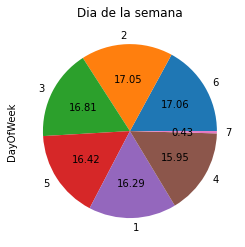

In [99]:
plot = train["DayOfWeek"].value_counts().plot(kind="pie",autopct="%.2f",title="Dia de la semana")

**Variable categorica Vs numerica**

**1. Promo Vs Sales**

**Visualmente**

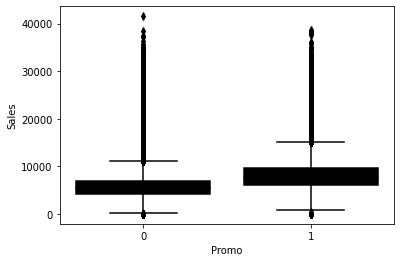

In [100]:
 sns.boxplot(x=train["Promo"],y=train["Sales"],data=train,color="black")


In [101]:
from scipy import stats

In [102]:
grupo = train[["Promo","Sales"]].groupby("Promo")
grupo.head(5)

,Promo,Sales
0,1,5263
1,1,6064
2,1,8314
3,1,13995
4,1,4822
5659,0,11421
5696,0,5773
5783,0,3742
5833,0,15998
5836,0,32547


**Test estadistico**

In [103]:
f_val,p_val = stats.f_oneway(grupo.get_group(0)["Sales"],grupo.get_group(1)["Sales"])

In [104]:
"{:f}".format(p_val)

'0.000000'

* **Los días de promo estan relacionados con la cantidad de ventas**

**2. SchoolHoliday Vs Sales**

**Visualmente**

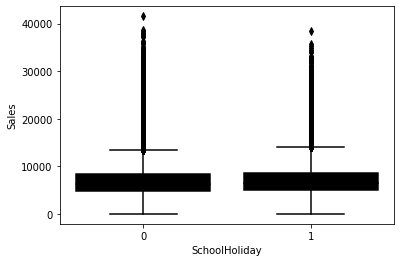

In [105]:
 sns.boxplot(x=train["SchoolHoliday"],y=train["Sales"],data=train,color="black")


In [106]:
grupo = train[["SchoolHoliday","Sales"]].groupby("SchoolHoliday")
grupo.head(5)

,SchoolHoliday,Sales
0,1,5263
1,1,6064
2,1,8314
3,1,13995
4,1,4822
12,0,8821
19,0,9593
21,0,6566
31,0,6395
35,0,12422


**Test estadistico**

In [107]:
f_val,p_val = stats.f_oneway(grupo.get_group(0)["Sales"],grupo.get_group(1)["Sales"])

In [108]:
"{:f}".format(p_val)

'0.000000'

* **Los días de escuela cerrada estan relacionados con la cantidad de ventas**

**3. StateHoliday Vs Sales**

**Visualmente**

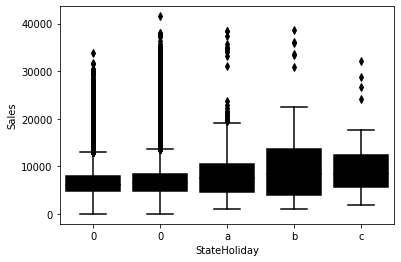

In [109]:
 sns.boxplot(x=train["StateHoliday"],y=train["Sales"],data=train,color="black")


In [110]:
grupo = train[["StateHoliday","Sales"]].groupby("StateHoliday")
grupo.head(5)

,StateHoliday,Sales
0,0,5263
1,0,6064
2,0,8314
3,0,13995
4,0,4822
...,...,...
327680,0,5732
327681,0,7470
327682,0,5484
327683,0,13801


**Test estadistico**

In [111]:
f_val,p_val = stats.f_oneway(grupo.get_group("a")["Sales"],grupo.get_group("b")["Sales"],grupo.get_group("c")["Sales"],grupo.get_group(0)["Sales"])

In [112]:
"{:f}".format(p_val)

'0.000000'

* **Los días de feriado estatal estan relacionados con la cantidad de ventas**
*Notacion StateHoliday: a = festivo, b = festivo de Pascua, c = Navidad, 0 = Ninguno*

**4. DayOfWeek Vs Sales**

**Visualmente**

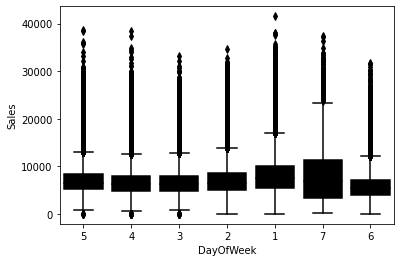

In [113]:
 sns.boxplot(x=train["DayOfWeek"],y=train["Sales"],data=train,color="black")


In [114]:
grupo = train[["DayOfWeek","Sales"]].groupby("DayOfWeek")
grupo.head(5)

,DayOfWeek,Sales
0,5,5263
1,5,6064
2,5,8314
3,5,13995
4,5,4822
...,...,...
6690,6,4364
6691,6,2512
6692,6,3878
6693,6,9322


**Test estadistico**

In [115]:
f_val,p_val = stats.f_oneway(grupo.get_group("1")["Sales"],grupo.get_group("2")["Sales"],grupo.get_group("3")["Sales"],grupo.get_group("4")["Sales"],grupo.get_group("5")["Sales"],grupo.get_group("6")["Sales"],grupo.get_group("7")["Sales"])

In [116]:
"{:f}".format(p_val)

'0.000000'

* **Los días de la semana estan relacionados con la cantidad de ventas**

**Variable numerica Vs numerica**

**Correlacion de Pearson**

In [117]:
train.corr()

,Sales,Customers
Sales,1.000000,0.823597
Customers,0.823597,1.000000


**Grado de significancia estadistica**

In [118]:
pearson_coef,p_value=stats.pearsonr(train["Customers"],train["Sales"])

In [119]:
"{:f}".format(p_value)

'0.000000'

In [120]:
pearson_coef

0.8235967321975433

**La correlación entre las ventas y el numero de clientes es estadisticamente significativa**

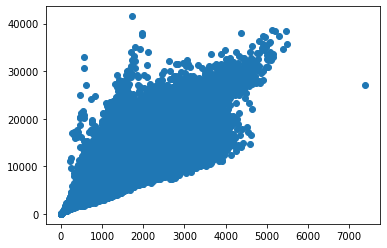

In [121]:
plt.scatter(train["Customers"],train["Sales"])
plt.show()

## **Selección de variables importantes**


## **Metodo de Correlación**

**Seleccionamos las variables numericas**

In [136]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 0 to 1017190
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Store          844392 non-null  object        
 1   DayOfWeek      844392 non-null  object        
 2   Date           844392 non-null  datetime64[ns]
 3   Sales          844392 non-null  int64         
 4   Customers      844392 non-null  int64         
 5   Open           844392 non-null  category      
 6   Promo          844392 non-null  category      
 7   StateHoliday   844392 non-null  category      
 8   SchoolHoliday  844392 non-null  category      
dtypes: category(4), datetime64[ns](1), int64(2), object(2)
memory usage: 81.9+ MB


**Identificar de forma automática variables numericas**

In [137]:
train.head(2)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1


In [138]:
variables_numericas = train._get_numeric_data().columns

In [139]:
variables_numericas

Index(['Sales', 'Customers'], dtype='object')

In [147]:
train1=train[variables_numericas]

In [148]:
train1.shape

(844392, 2)

In [149]:
train1.columns

Index(['Sales', 'Customers'], dtype='object')

**Funcion**

In [175]:
def rstr(train, pred=None): 
    obs = train.shape[0]
    types = train.dtypes
    counts = train.apply(lambda x: x.count())
    uniques = train.apply(lambda x: [x.unique()])
    uniques=uniques.iloc[0,:]
    nulls = train.apply(lambda x: x.isnull().sum())
    distincts = train.apply(lambda x: x.unique().shape[0])
    missing_ration = (train.isnull().sum()/ obs) * 100
    skewness = train.skew()
    kurtosis = train.kurt() 
    print('Data shape:', train.shape)
    if pred is None:
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing ration', 'uniques', 'skewness', 'kurtosis']
        str = pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis], axis = 1)
    else:
        corr = train.corr()[pred]
        str = pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis, corr], axis = 1, sort=False)
        corr_col = 'corr '  + pred
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing_ration', 'uniques', 'skewness', 'kurtosis', corr_col ]
    
    str.columns = cols
    dtypes = str.types.value_counts()
    return str

In [176]:
details = rstr(train1, "Sales")
display(details.sort_values(by='corr Sales', ascending=False))

Data shape: (844392, 2)


,types,counts,distincts,nulls,missing_ration,uniques,skewness,kurtosis,corr Sales
Sales,int64,844392,21734,0,0.000000,"[5263, 6064, 8314, 13995, 4822, 5651, 15344, 8...",1.593922,4.852012,1.000000
Customers,int64,844392,4086,0,0.000000,"[555, 625, 821, 1498, 559, 589, 1414, 833, 687...",2.788110,13.313755,0.823597


In [178]:
num_columnas=["Customers"] # Numericas
cat_columnas=[]# Categoricas

# **4. Modelacion**

## **4.1. Regresion Simple**

In [192]:
datos=train1[["Sales","Customers"]]

**Division de Entrenamiento y Prueba**

* Mayor proporcion para entrenar
* Baja proporcion para probar

In [193]:
from sklearn.model_selection import  train_test_split

In [195]:
X=datos[["Customers"]]
Y=datos["Sales"].values

In [196]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,train_size=0.8)

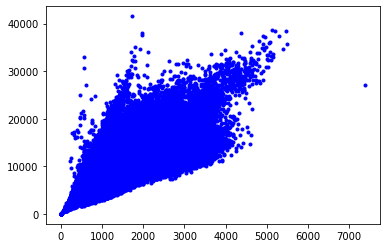

In [198]:
plt.plot(X,Y,"b.")
plt.show()

In [199]:
from sklearn.linear_model import LinearRegression

In [200]:
Modelo_Lineal_Simple=LinearRegression()# funcion


In [201]:
#Entrenamiento comando fit
Modelo_Lineal_Simple.fit(x_train,y_train)
LinearRegression(copy_X=True,fit_intercept=True,n_jobs=None,normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [202]:
Modelo_Lineal_Simple.coef_

array([6.36955584])

In [203]:
Modelo_Lineal_Simple.intercept_

2096.2684424031313

* Cantidad_de_ventas = 2096.2684424031313 + 6.36955584 * Cantidad de clientes en un determinado día + error

* Si la tienda tiene un visitante más, se espera un incremento de 6.36955584 ventas.

In [208]:
predit=Modelo_Lineal_Simple.predict(x_train)
predit

array([ 4822.43834079,  4128.15675452, 11746.14553599, ...,
        8644.1718432 ,  9357.56209699,  6115.45817577])

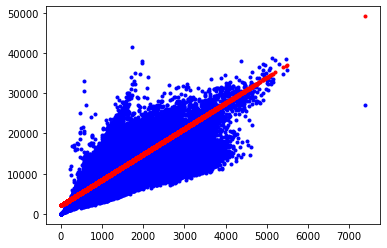

In [212]:
plt.plot(X,Y,"b.")
plt.plot(x_train,predit,"r.")
plt.show()

**Predicciones con datos nuevos**

In [213]:
Prediccion_datos_nuevos = Modelo_Lineal_Simple.predict(x_test)

In [214]:
Prediccion_datos_nuevos

array([7440.32578994, 4911.61212251, 5427.54614534, ..., 7134.58710975,
       5924.37150065, 6172.78417831])

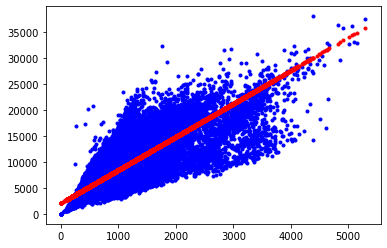

In [217]:
plt.plot(x_test,y_test,"b.")
plt.plot(x_test,Prediccion_datos_nuevos,"r.")
plt.show()

Terminé la clase del 2 de junio